##  Notebook 00b: sub-SEVIR Regression ML Models 

### Goal: Train and evaluate regression ML models on the sub-SEVIR dataset 

In this notebook, we train and evaluate regression machine learning (ML) models on the sub-SEVIR dataset. sub-SEVIR is a lower-resolution version of the Storm Event Imagery Dataset. The new spatial resolution is 8 km with a 60 min timestep resolution for each event. Our goal is to train a regression model to predict the number of lightning flashes. 

For simplicity, we limited our model selection to linear regression, random forests, and gradient-boosted trees. For each model, the default hyperparameters were used. 

#### Import the neccesary packages

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline 
import joblib

In [2]:
import sys,os
top_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(top_path,'scripts/'))

# Plots ROC, performance, and reliability diagram given a model, X, and y
from verification import plot_taylor_diagram, plot_verification_scatter
from util import load_ml_data 

### Load the data 

We have provided a IO function for loading the ML data. Uncomment the following cell and execute it to learn more about the input arguments. 

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data(task='regression')

### Create the model pipelines and fit the models

When training ML models, we often have to pre-processing the data. For this example, we want to scaling the data so that each feature has a mean of zero and variance of 1. Scikit-learn has a great feature known as [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) where the pre-processing is incorporated into the model. Thus, when you call `.predict` or `.predict_proba`, the pre-processing is applied internally. 


In [4]:
# Make a pipeline. 
steps = [('StandardScaler', StandardScaler())]

regs = [( 'LR', LinearRegression()), 
        ( 'GBT', HistGradientBoostingRegressor()), 
        ( 'RF', RandomForestRegressor())
       ]

fit_regs = [(e[0], Pipeline(steps+[e]).fit(X_train, y_train)) for e in regs]

### Verification Step 1. Plot the scatter

For initial verification, it is useful to plot the predict and true flash amounts. 

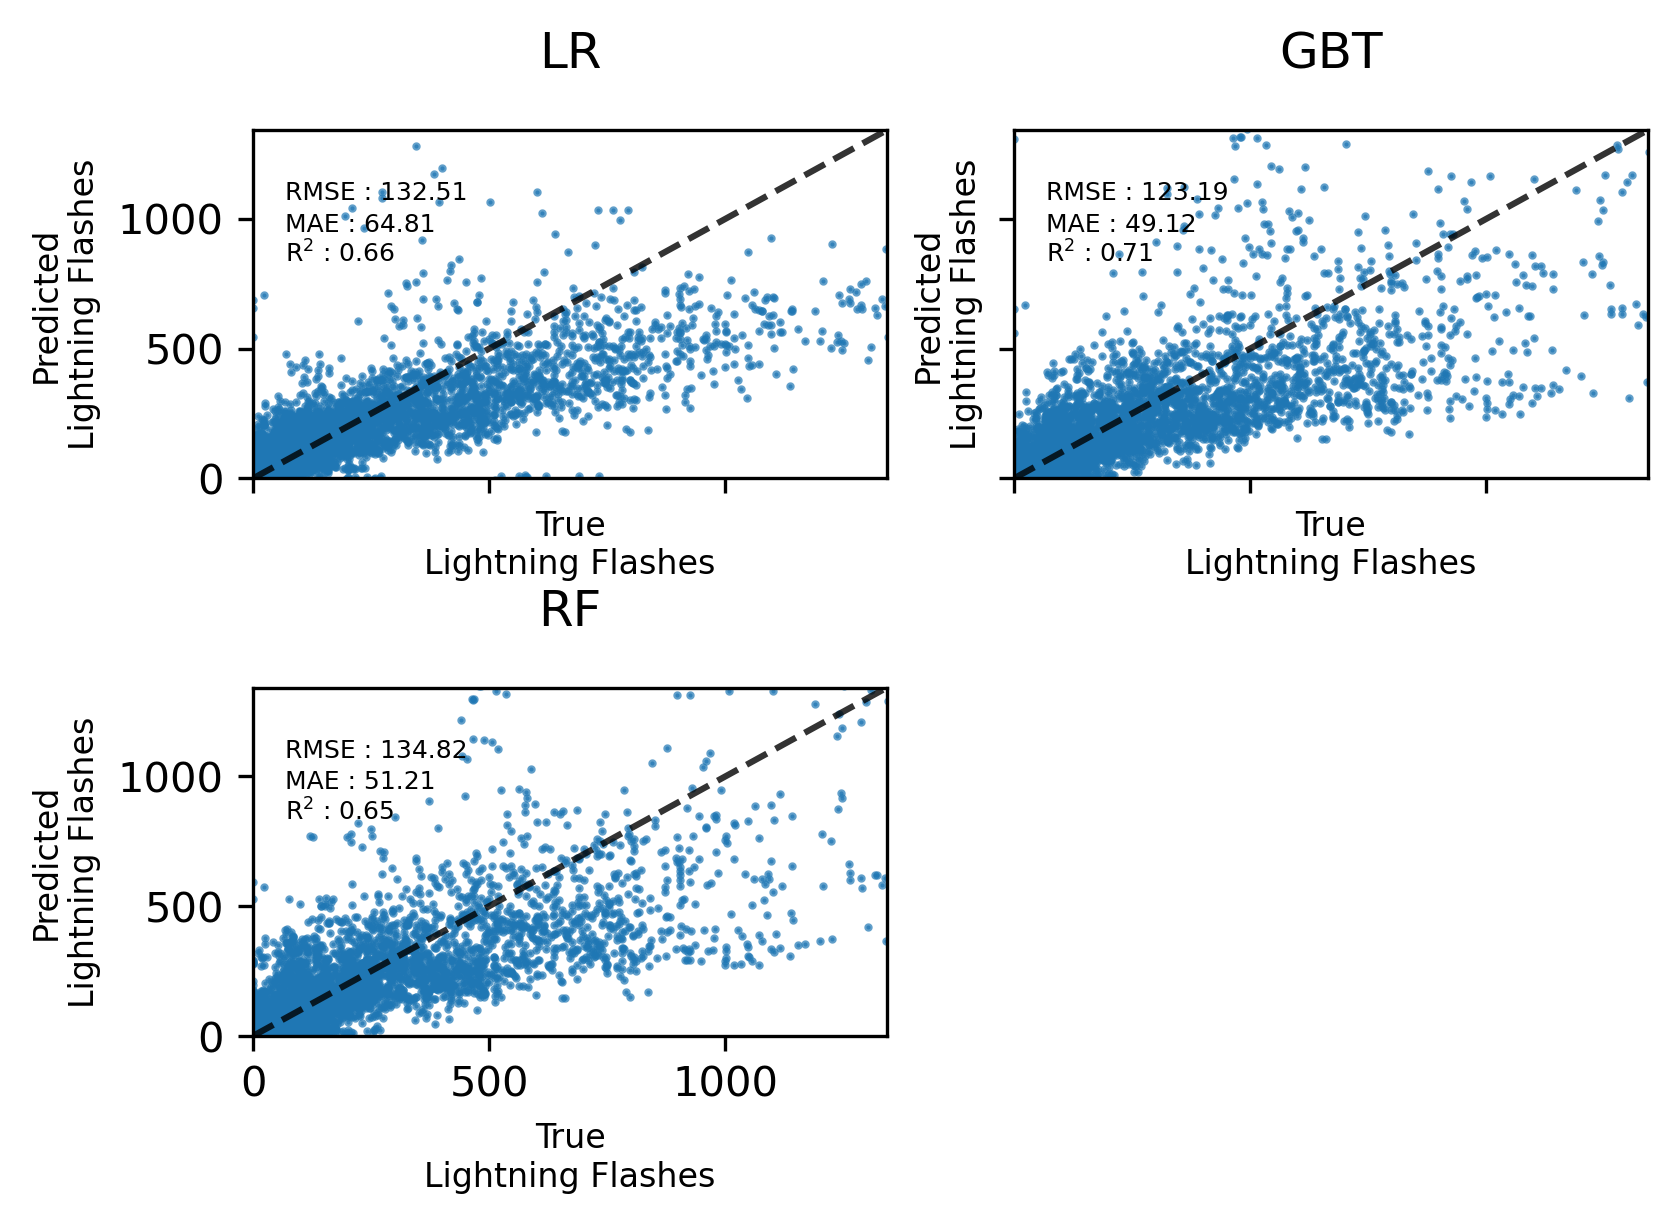

In [5]:
plot_verification_scatter(fit_regs, X_test, y_test, add_kde=False)

### Verification Step 2. Plot the Taylor Diagram 

The Taylor diagram shows multiple regression statistics on a single diagram. The following statistics are shown:
1. Standard Deviation (radial distance from origin)
    * The prediction variance should capture the variance in the target variable. Additionally, RMSE can be biased low if the prediction variance is underpredicted. 

2. Correlation (angle from the x-axis)
    * Ideally, the prediction should be linearly correlated with the target variable.
3. Centered Root Mean Squared Error (RMSE; radially distance from the star)
    * The centered RMSE can be though of the RMSE after being corrected for bias, so it tends to be lower than the actual RMSE. 
4. Bias (difference between target mean and prediction mean; color coding of the dot)
    * Ideally, bias should be zero. 

All three models are well correlated with the target variable, but are underpredicting the true spread and have a small, negative bias. The cRMSE is 125 flashes. 


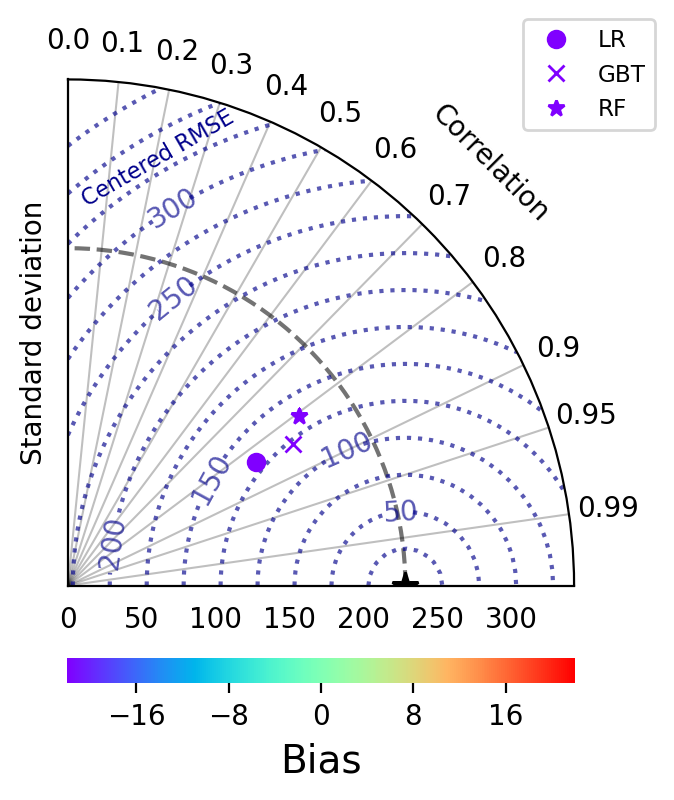

In [6]:
plot_taylor_diagram(fit_regs, X_test, y_test.values, n_boot=10)

### Save the models using joblib

In [7]:
import joblib 
from os.path import join

# Save the models 
path = '../models'
for name, reg in fit_regs:
    joblib.dump(reg, join(path, f'{name}_regression.joblib'), compress=3)